Y-DATA 2020/21<br/>
Deep Learning HW2<br/>
Serge Tochilov

# Training Neural Networks

Neural networks with nonlinear activations work like universal function approximators. Suppose there is some function that maps your input to the output. For example, images of handwritten digits to class probabilities. The power of a neural network is that we can train it to approximate this function, and basically any function given enough data and computation time.

<center><img src='https://github.com/udacity/deep-learning-v2-pytorch/blob/master/intro-to-pytorch/assets/function_approx.png?raw=true' width=500px></center>

Initially the network is naive, it doesn't know the function mapping the inputs to the outputs. We train the network by showing it examples of real data, then adjusting the network parameters in such a way that it approximates this function better and better.

To find these parameters, we need to know how good the network is predicting the real outputs. For this purpose we calculate a **loss (or cost) function**, a measure of our prediction error. For example, mean squared loss is often used in regression and binary classification problems:

$$
\large \ell = \frac{1}{2n}\sum_i^n{\left(y_i - \hat{y}_i\right)^2}
$$

where $n$ is the number of training examples, $y_i$ are the true labels, and $\hat{y}_i$ are the predicted labels.

By minimizing the loss with respect to the network parameters, we can find configurations where the loss is at a minimum, and the network is able to predict the correct labels with high accuracy. We find this minimum using so-called **gradient descent**. The gradient is the slope of the loss function and points in the direction of its fastest change. To get to the minimum in the least amount of time, we then want to follow the gradient (downwards). You can think of this like descending a mountain by following the steepest slope.

<center><img src='https://github.com/udacity/deep-learning-v2-pytorch/blob/master/intro-to-pytorch/assets/gradient_descent.png?raw=true' width=350px></center>

## Backpropagation

For single layer networks gradient descent is straightforward to implement. However, it's more complicated for deeper, multilayer neural networks. Sufficient to say that it took about 30 years before researchers figured out how to train multilayer networks.

Training multilayer networks is performed through **backpropagation** which is an application of the chain rule from calculus. Let's convert a two layer neural network into a graph representation to illustrate the process.

<center><img src='https://github.com/udacity/deep-learning-v2-pytorch/blob/master/intro-to-pytorch/assets/backprop_diagram.png?raw=true' width=550px></center>

In the forward pass through the network, our data and operations go from bottom to top here. We pass the input $x$ through a linear transformation $L_1$ with weights $W_1$ and biases $b_1$. The output then goes through the sigmoid operation $S$ and another linear transformation $L_2$. Finally, we calculate the loss $\ell$. We use the loss as a measure of how good the network's predictions are. The goal then is to adjust the weights and biases to minimize the loss.

To train the weights by gradient descent, we propagate the gradient of the loss backwards through the network. Each operation has some gradient between the inputs and outputs. As we send the gradients backwards, we multiply the incoming gradient with the gradient for the operation. Mathematically it is equivalent to calculating the gradient of the loss with respect to the weights using the chain rule.

$$
\large \frac{\partial \ell}{\partial W_1} = \frac{\partial L_1}{\partial W_1} \frac{\partial S}{\partial L_1} \frac{\partial L_2}{\partial S} \frac{\partial \ell}{\partial L_2}
$$

**Note:** I'm glossing over a few details here that require some knowledge of vector calculus, but they aren't necessary to understand what's going on.

We update our weights using this gradient with some learning rate $\alpha$. 

$$
\large W^\prime_1 = W_1 - \alpha \frac{\partial \ell}{\partial W_1}
$$

The learning rate $\alpha$ is set such that the weight update steps are small enough that the iterative method settles in a minimum.

## Losses in PyTorch

Let's start with calculating the loss in PyTorch. Through the `nn` module, PyTorch provides losses such as cross-entropy loss (`nn.CrossEntropyLoss`). You'll usually see the loss assigned to `criterion`. For classification problems such as MNIST, we use the softmax function to predict class probabilities. With a softmax output, we need to use cross-entropy as the loss. To actually calculate the loss, we first define the criterion, then pass in it the output of your network and the correct labels.

Really important note. Look at [the documentation for `nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/nn.html#torch.nn.CrossEntropyLoss),

> This criterion combines `nn.LogSoftmax()` and `nn.NLLLoss()` in one single class.
>
> The input is expected to contain scores for each class.

It means that we need to pass in `nn.CrossEntropyLoss` the raw output of our network into, not the output of the softmax function. This raw output is usually called the *logits* or *scores*. We use the logits because softmax gives you probabilities, which will often be very close to zero or one but floating-point numbers can't accurately represent values near zero or one ([read more here](https://docs.python.org/3/tutorial/floatingpoint.html)). It's usually better to avoid doing calculations with probabilities, and generally we use log-probabilities.

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms

# define a transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# download and load the training data
trainset = datasets.MNIST('MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)


Extracting MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/MNIST/raw



Extracting MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



Extracting MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/MNIST/raw



Extracting MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:479: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
# build a feed-forward network
model = nn.Sequential(
    nn.Linear(784, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 10))

# define the loss
criterion = nn.CrossEntropyLoss()

# get our data
dataiter = iter(trainloader)
images, labels = next(dataiter)

# flatten images
images = images.view(images.shape[0], -1)

# forward pass, get our logits
logits = model(images)

# calculate the loss with the logits and the labels
loss = criterion(logits, labels)

print(loss)

tensor(2.2943, grad_fn=<NllLossBackward>)


It's more convenient to build the model with a log-softmax output using `nn.LogSoftmax` or `F.log_softmax` ([documentation](https://pytorch.org/docs/stable/nn.html#torch.nn.LogSoftmax)). In that case you can get the actual probabilities by taking exponentials `torch.exp(output)`. With a log-softmax output, you need to use the negative log-likelihood loss `nn.NLLLoss` ([documentation](https://pytorch.org/docs/stable/nn.html#torch.nn.NLLLoss)).

**Exercise:** Build a model that returns the log-softmax as the output and calculate the loss using the negative log-likelihood loss. Note that for `nn.LogSoftmax` and `F.log_softmax` you'll need to set the `dim` keyword argument appropriately. `dim=0` calculates softmax across the rows, so each column sums to 1, while `dim=1` calculates across the columns so each row sums to 1. Think about what you want the output to be and choose `dim` appropriately.

In [ ]:
# TODO: build a feed-forward network

# build a feed-forward network
model = nn.Sequential(
    nn.Linear(784, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 10),
    nn.LogSoftmax(dim=1))

# TODO: define the loss
criterion = nn.NLLLoss()

### Run this to check your work

# get our data
dataiter = iter(trainloader)
images, labels = next(dataiter)

# flatten images
images = images.view(images.shape[0], -1)

# forward pass, get our logits
logits = model(images)

# calculate the loss with the logits and the labels
loss = criterion(logits, labels)

print(loss)

tensor(2.3120, grad_fn=<NllLossBackward>)


## Autograd

Now that we know how to calculate a loss, how do we use it to perform backpropagation? Torch provides a module, `autograd`, which automatically calculates the gradients of tensors. We can use it to calculate the gradients of all our parameters with respect to the loss. Autograd works by keeping track of operations performed on tensors, then going backwards through those operations, calculating gradients along the way. To make sure PyTorch keeps track of operations on a tensor and calculates the gradients, you need to set `requires_grad = True` on a tensor. You can do this at creation with the `requires_grad` keyword, or at any time with `x.requires_grad_(True)`.

You can turn off gradients for a block of code with the `torch.no_grad()` content:
```python
x = torch.zeros(1, requires_grad=True)
>>> with torch.no_grad():
...     y = x * 2
>>> y.requires_grad
False
```

Also, you can turn on or off gradients altogether with `torch.set_grad_enabled(True|False)`.

The gradients are computed with respect to some variable `z` with `z.backward()`. This does a backward pass through the operations that created `z`.

In [ ]:
x = torch.randn(2,2, requires_grad=True)
print(x)

tensor([[ 0.7983, -1.3221],
        [-0.3591,  0.7153]], requires_grad=True)


In [ ]:
y = x**2
print(y)

tensor([[0.6373, 1.7480],
        [0.1290, 0.5117]], grad_fn=<PowBackward0>)


Below we can see the operation that created `y`, a power operation `PowBackward0`.

In [ ]:
# grad_fn shows the function that generated this variable
print(y.grad_fn)

The autograd module keeps track of these operations and knows how to calculate the gradient for each one. In this way, it's able to calculate the gradients for a chain of operations, with respect to any one tensor. Let's reduce the tensor `y` to a scalar value, the mean.

In [ ]:
z = y.mean()
print(z)

tensor(0.7565, grad_fn=<MeanBackward0>)


You can check the gradients for `x` and `y` but they are empty currently.

In [ ]:
print(x.grad)

None


To calculate the gradients, you need to run the `.backward` method on a variable, `z` for example. It will calculate the gradient for `z` with respect to `x`

$$
\large \frac{\partial z}{\partial x} = \frac{\partial}{\partial x}\left[\frac{1}{n}\sum_i^n x_i^2\right] = \frac{x}{2}
$$

In [ ]:
z.backward()
print(x.grad)
print(x/2)

tensor([[ 0.3992, -0.6611],
        [-0.1796,  0.3577]])
tensor([[ 0.3992, -0.6611],
        [-0.1796,  0.3577]], grad_fn=<DivBackward0>)


These gradient calculations are particularly useful for neural networks. For training, we need the gradients of the cost with respect to the weights. With PyTorch we run data forward through the network to calculate the loss, then go backwards to calculate the gradients with respect to the loss. Once we have the gradients, we can perform a gradient descent step.

## Loss and Autograd together

When we create a network with PyTorch, all the parameters are initialized with `requires_grad = True`. It means that when we calculate the loss and call `loss.backward()`, the gradients for the parameters are calculated under the hood. These gradients are later used to update the weights with gradient descent. Below you can see an example of calculating the gradients using a backwards pass.

In [ ]:
# build a feed-forward network
model = nn.Sequential(
    nn.Linear(784, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 10),
    nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
dataiter = iter(trainloader)
images, labels = next(dataiter)
images = images.view(images.shape[0], -1)

logits = model(images)
loss = criterion(logits, labels)

In [ ]:
print('Before backward pass: \n', model[0].weight.grad)

loss.backward()

print('After backward pass: \n', model[0].weight.grad)

Before backward pass: 
 None
After backward pass: 
 tensor([[ 3.3119e-03,  3.3119e-03,  3.3119e-03,  ...,  3.3119e-03,
          3.3119e-03,  3.3119e-03],
        [ 1.3022e-03,  1.3022e-03,  1.3022e-03,  ...,  1.3022e-03,
          1.3022e-03,  1.3022e-03],
        [ 3.8247e-05,  3.8247e-05,  3.8247e-05,  ...,  3.8247e-05,
          3.8247e-05,  3.8247e-05],
        ...,
        [-2.4438e-04, -2.4438e-04, -2.4438e-04,  ..., -2.4438e-04,
         -2.4438e-04, -2.4438e-04],
        [-6.3511e-04, -6.3511e-04, -6.3511e-04,  ..., -6.3511e-04,
         -6.3511e-04, -6.3511e-04],
        [ 6.5157e-04,  6.5157e-04,  6.5157e-04,  ...,  6.5157e-04,
          6.5157e-04,  6.5157e-04]])


## Training the network

There's one last piece we need to start training, an optimizer that we'll use to update the weights with the gradients. We get these from PyTorch [`optim` package](https://pytorch.org/docs/stable/optim.html). For example, we can use stochastic gradient descent with `optim.SGD`. You can see how to define an optimizer below.

In [ ]:
from torch import optim

# optimizers require the parameters to optimize and a learning rate
optimizer = optim.SGD(model.parameters(), lr=0.01)

Now we know how to use all the individual parts, so it's time to see how they work together. Let's consider just one learning step before looping through all the data. The general process with PyTorch:

* Make a forward pass through the network 
* Use the network output to calculate the loss
* Perform a backward pass through the network with `loss.backward()` to calculate the gradients
* Take a step with the optimizer to update the weights

Below we'll go through one training step and print out the weights and gradients, so you can see how they change. Note that we have a line of code `optimizer.zero_grad()`. When you do multiple backwards passes with the same parameters, the gradients are accumulated. This means that you need to zero the gradients on each training pass, or you'll retain gradients from previous training batches.

In [ ]:
print('Initial weights ---\n', model[0].weight)

dataiter = iter(trainloader)
images, labels = next(dataiter)
images.resize_(64, 784)

# clear the gradients, do this because gradients are accumulated
optimizer.zero_grad()

# forward pass, then backward pass
output = model(images)
loss = criterion(output, labels)
loss.backward()
print('\nGradient ---\n', model[0].weight.grad)

# take an update step and view the new weights
optimizer.step()
print('\nUpdated weights ---\n', model[0].weight)

Initial weights ---
 Parameter containing:
tensor([[ 0.0025,  0.0037, -0.0148,  ..., -0.0240,  0.0344,  0.0002],
        [ 0.0333,  0.0303, -0.0251,  ...,  0.0111, -0.0334, -0.0208],
        [ 0.0185,  0.0183,  0.0168,  ..., -0.0037,  0.0097, -0.0111],
        ...,
        [-0.0254,  0.0266,  0.0156,  ...,  0.0004, -0.0002,  0.0266],
        [-0.0191, -0.0256,  0.0081,  ...,  0.0234,  0.0122,  0.0264],
        [-0.0270, -0.0162,  0.0157,  ..., -0.0217, -0.0329,  0.0025]],
       requires_grad=True)

Gradient ---
 tensor([[-0.0033, -0.0033, -0.0033,  ..., -0.0033, -0.0033, -0.0033],
        [ 0.0005,  0.0005,  0.0005,  ...,  0.0005,  0.0005,  0.0005],
        [ 0.0009,  0.0009,  0.0009,  ...,  0.0009,  0.0009,  0.0009],
        ...,
        [-0.0018, -0.0018, -0.0018,  ..., -0.0018, -0.0018, -0.0018],
        [ 0.0008,  0.0008,  0.0008,  ...,  0.0008,  0.0008,  0.0008],
        [-0.0039, -0.0039, -0.0039,  ..., -0.0039, -0.0039, -0.0039]])

Updated weights ---
 Parameter containing:
ten

## Training for real

Now we'll put this algorithm into a loop that goes through all the images. Some nomenclature, one pass through the entire dataset is called an *epoch*. So here we're going to loop through `trainloader` to get our training batches. For each batch, we perform a training pass where we calculate the loss, then a backwards pass, and finally update the weights.

**Exercise:** Implement the training pass for our network. If you implemented it correctly, you should see the training loss drop with each epoch.

In [ ]:
## Your solution here

model = nn.Sequential(
    nn.Linear(784, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 10),
    nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003)

epochs = 5 
for e in range(epochs):

    running_loss = 0
    for images, labels in trainloader:

        # flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        # TODO: Training pass
        
        # clear the gradients, do this because gradients are accumulated
        optimizer.zero_grad()

        # forward pass
        output = model(images)
        loss = criterion(output, labels)
        running_loss += loss.item()

        # backward pass
        loss.backward()

        # update step
        optimizer.step()
    else:
        print(f'Epoch {e+1}/{epochs}  Training loss: {running_loss/len(trainloader)}')

Epoch 1/5  Training loss: 1.8420514529193643
Epoch 2/5  Training loss: 0.77595338692416
Epoch 3/5  Training loss: 0.5043708988503098
Epoch 4/5  Training loss: 0.42444651816953727
Epoch 5/5  Training loss: 0.3845194144639125


With the network trained, we can check out it's predictions.

In [ ]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt


def view_classify(img, ps_arr, lbl_arr):
    '''
    Function for viewing an image and it's predicted classes. '''

    l_ps = len(ps_arr)

    fig, axs = plt.subplots(figsize=(3*l_ps, 3), ncols=l_ps*2)

    for i in range(l_ps):
        ps = ps_arr[i].data.numpy().squeeze()
        lbl = lbl_arr[i].item()
        lbl_max = np.argmax(ps)
        
        j = i*2
        axs[j].imshow(img[i].resize_(1, 28, 28).numpy().squeeze(), cmap='Greys')
        axs[j].axis('off')
        axs[j+1].barh(np.arange(10), ps)
        axs[j+1].barh(lbl_max, ps[lbl_max], color='red')
        axs[j+1].barh(lbl, ps[lbl], color='green')
        axs[j+1].set_aspect(0.2)
        axs[j+1].set_yticks(np.arange(10))
        axs[j+1].set_yticklabels(np.arange(10))
        axs[j+1].set_title('Class Probability')
        axs[j+1].set_xlim(0, 1)

    plt.tight_layout()

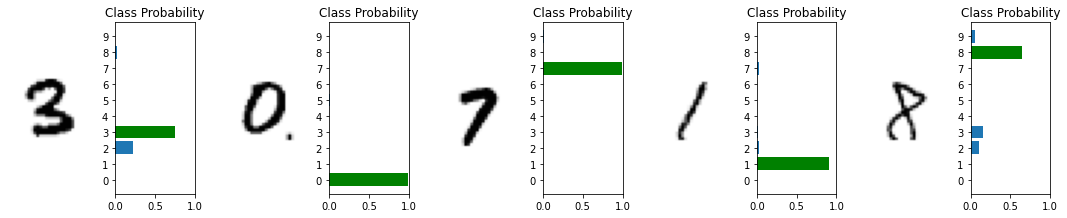

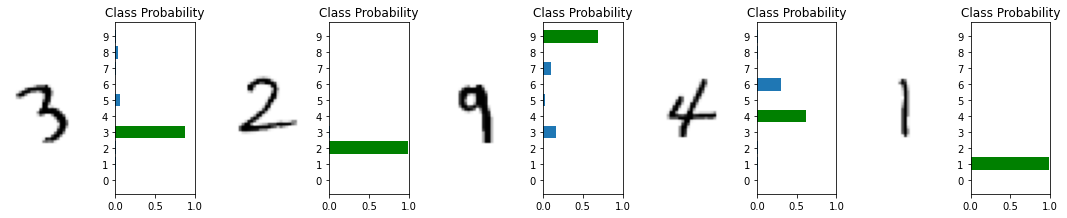

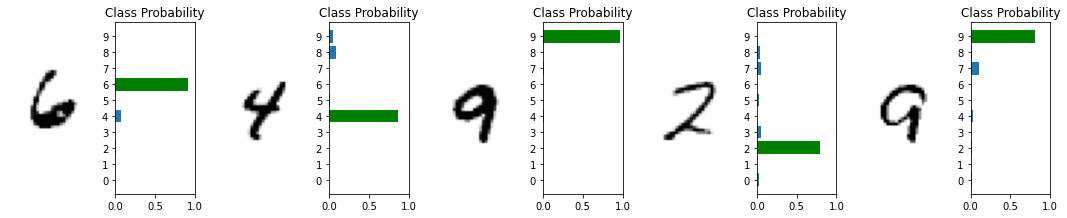

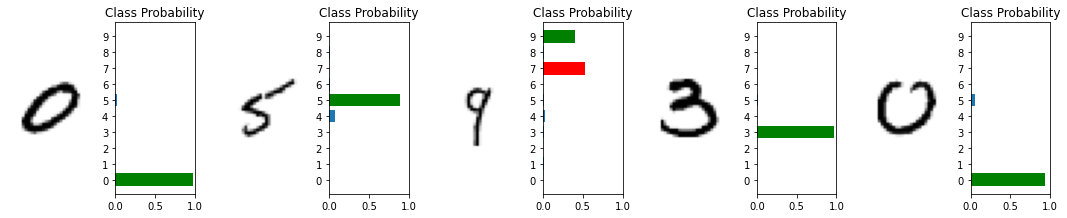

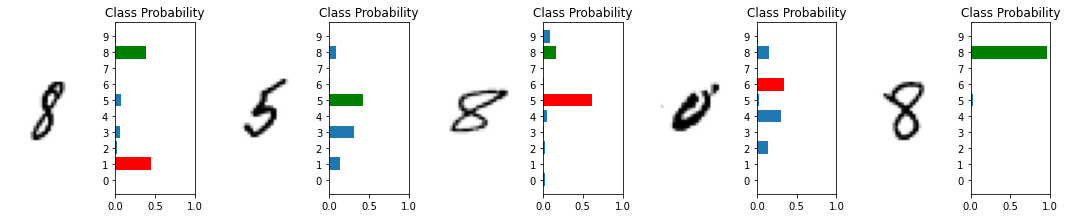

In [ ]:
dataiter = iter(trainloader)

i_r = 5
for i in range(5):
    images, labels = next(dataiter)

    img = images[:i_r].view(5, 784)
    lbl = labels[:i_r]

    # turn off gradients to speed up this part
    with torch.no_grad():
        logps = model(img)

    # output of the network are log-probabilities, need to take exponential for probabilities
    view_classify(img.view(i_r, 28, 28), torch.exp(logps), lbl)